In [1]:

import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.nn import functional as F
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DistilBertModel
from torch.utils.data import DataLoader, WeightedRandomSampler

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
### Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
plt_params ={
    'font.family': 'serif',
    'font.size': '16',
    'font.weight': 'normal',
    'axes.grid': True,
}
plt.rcParams.update(plt_params)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
torch.cuda.empty_cache()

In [5]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


#### Import data

In [7]:
raw_data = load_dataset('emotion')

Using custom data configuration default
Reusing dataset emotion (/home/sabber/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
from collections import Counter
print(Counter(raw_data['train']['label']))
print(Counter(raw_data['validation']['label']))
print(Counter(raw_data['test']['label']))

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})
Counter({1: 704, 0: 550, 3: 275, 4: 212, 2: 178, 5: 81})
Counter({1: 695, 0: 581, 3: 275, 4: 224, 2: 159, 5: 66})


In [9]:
train = raw_data['train'].to_pandas()
validation = raw_data['validation'].to_pandas()
test = raw_data['test'].to_pandas()

In [10]:
train.shape, validation.shape, test.shape

((16000, 2), (2000, 2), (2000, 2))

In [11]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
label_unique, counts = np.unique(train['label'], return_counts=True)
class_weight = [sum(counts) / count for count in counts]

In [13]:
class_weight

[3.4290612944706385,
 2.9839612085042893,
 12.269938650306749,
 7.410838351088467,
 8.260196179659268,
 27.972027972027973]

In [14]:
example_weight = [class_weight[i] for i in train['label']]

In [15]:
sampler = WeightedRandomSampler(example_weight, num_samples=len(train))

### One hot encode lables

In [16]:
encoder = OneHotEncoder(handle_unknown='ignore')

In [17]:
train_labels = pd.DataFrame(encoder.fit_transform(train[['label']]).toarray())
validation_labels = pd.DataFrame(encoder.fit_transform(validation[['label']]).toarray())
test_labels = pd.DataFrame(encoder.fit_transform(test[['label']]).toarray())

### Define parameters

In [18]:
## Parameters
LEARNING_RATE:float = 0.0001
EPOCHS:int = 100
BATCH_SIZE:int = 1024
TEXT_MAX_LEN = 16
SHUFFLE:bool = True
NUM_CLASSES:int = train_labels.shape[1]
VALID_DATA_PERCENTAGE:float = 0.2

In [19]:

class EmotionDataset:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
            
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        inputs = self.tokenizer(text, max_length=self.max_len,
                                        padding="max_length", truncation=True, return_tensors='pt')
        
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

In [20]:
## Dataset
train_dataset = EmotionDataset(train['text'].tolist(), train_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)
validation_dataset = EmotionDataset(validation['text'].tolist(), validation_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)
test_dataset = EmotionDataset(test['text'].tolist(), test_labels.to_numpy(), tokenizer, max_len=TEXT_MAX_LEN)

In [21]:
### Data loader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, pin_memory=True, sampler = sampler)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=2000, pin_memory=True, shuffle=False)

In [ ]:
class EmotionClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.distillbert = DistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=True)
        self.layer_1 = nn.Linear(768, 32)
        self.layer_4 = nn.Linear(32, NUM_CLASSES)
        self.dropout = nn.Dropout(0.55)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.learning_rate = LEARNING_RATE
        
    def forward(self, ids, masks):
        distill_out = self.distillbert(ids.squeeze(), masks.squeeze())
        pooled_output = distill_out[0]
        pooled_output = pooled_output[:, 0]
        
        output = self.relu(pooled_output)
        output = self.relu(self.dropout(self.layer_1(output)))
        logits = self.layer_4(output)
        return logits
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        ids = batch["ids"]
        mask = batch["mask"]
        targets = batch["labels"]
        
        outputs = model(ids=ids, masks=mask)
        loss = F.cross_entropy(outputs, targets.float())
        self.log('train_loss', loss, prog_bar=True)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        ids = batch["ids"]
        mask = batch["mask"]
        targets = batch["labels"]
        
        outputs = model(ids=ids, masks=mask)
        loss = F.cross_entropy(outputs, targets.float())
        self.log('val_loss', loss, prog_bar=True)
        return {'val_loss': loss}
    
    def test_step(self, batch, batch_idx):
        ids = batch["ids"]
        mask = batch["mask"]
        targets = batch["labels"]
        
        outputs = model(ids=ids, masks=mask)
        loss = F.cross_entropy(outputs, targets.float())
        self.log('test_loss', loss, prog_bar=True)
        return {'test_loss': loss, 'logits': outputs}
    
    def predict_step(self, batch, batch_idx):
        ids = batch["ids"]
        mask = batch["mask"]
        targets = batch["labels"]
        preds = model(ids=ids, masks=mask)

        return torch.argmax(preds, dim=1)
    
model = EmotionClassifier()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", min_delta=0.005, patience=5, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs = EPOCHS, accelerator='gpu', devices=1, callbacks=[early_stopping], auto_lr_find=True, log_every_n_steps=5)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_dataloader, validation_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type            | Params
------------------------------------------------
0 | distillbert | DistilBertModel | 66.4 M
1 | layer_1     | Linear          | 24.6 K
2 | layer_4     | Linear          | 198   
3 | dropout     | Dropout         | 0     
4 | relu        | ReLU            | 0     
------------------------------------------------
66.4 M    Trainable params
0         Non-trainable params
66.4 M    Total params
265.551   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

2022-06-14 07:22:20.285765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 07:22:20.285788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 1.330


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.342 >= min_delta = 0.005. New best score: 0.988


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.173 >= min_delta = 0.005. New best score: 0.815


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.095 >= min_delta = 0.005. New best score: 0.721


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.024 >= min_delta = 0.005. New best score: 0.697


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.030 >= min_delta = 0.005. New best score: 0.666


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.666. Signaling Trainer to stop.


### test prediction

In [ ]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8464177846908569
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8464177846908569}]

In [ ]:
test_pred = trainer.predict(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 16it [00:00, ?it/s]

In [ ]:
t = test_pred[0].cpu().numpy()

In [ ]:
print(classification_report(test.label.values, t))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       581
           1       0.81      0.81      0.81       695
           2       0.61      0.64      0.63       159
           3       0.74      0.73      0.74       275
           4       0.78      0.68      0.73       224
           5       0.67      0.65      0.66        66

    accuracy                           0.77      2000
   macro avg       0.73      0.72      0.73      2000
weighted avg       0.77      0.77      0.77      2000



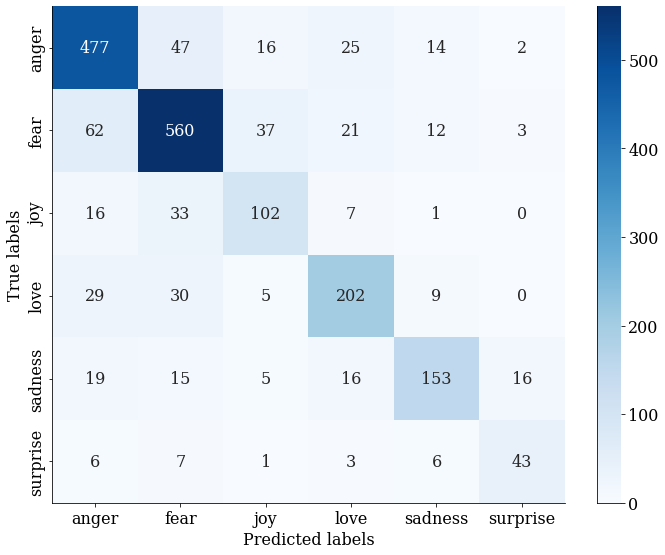

In [ ]:
cm = confusion_matrix(test.label.values, t)
unique_labels = ['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']
df_cm = pd.DataFrame(cm, columns=np.unique(unique_labels), index = np.unique(unique_labels))
plt.figure(figsize = (10, 8))
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='d')
sns.despine()
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.tight_layout()

### Visualize the results

In [ ]:
epochs = np.arange(1, EPOCHS +1)
plt.figure(figsize=(10,5))
sns.lineplot(x = epochs, y = train_loss, label = "Train Loss")
sns.lineplot(x = epochs, y = validation_loss, label = "Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.grid()
sns.despine()
plt.tight_layout()

NameError: name 'train_loss' is not defined

<Figure size 720x360 with 0 Axes>

In [ ]:
def get_emotion(text):
  input_ids = tokenizer.encode(text, return_tensors='pt')

  output = model.generate(input_ids=input_ids,
               max_length = TEXT_MAX_LEN)
  
  dec = [tokenizer.decode(ids) for ids in output]
  label = dec[0]
  return label